In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix, roc_curve, log_loss, make_scorer
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from collections import defaultdict
import xgboost as xgb

from IPython.display import Image



In [6]:
def read_dataset(path, start_idx, end_idx):
    frames = [ pd.read_json(f) for f in [path.format(i) for i in range(start_idx, end_idx+1)] ]
    return pd.concat(frames, ignore_index = True)

In [7]:
file_path = '/home/ethan/Documents/dataset_initial/dataset_{:02}.json'

df = read_dataset(file_path, 0, 17)

In [14]:
df =  df.loc[df['round_status'] == 'FreezeTime']

In [22]:
df['target'] = (df['round_winner'] == 'CT').astype(int)

In [23]:
def get_attr(df, team, attr=None):
    team_players = map(lambda players: filter(lambda p: p["team"] == team, players), df['alive_players'])
    if attr:
        team_players = map(lambda players: map(lambda p: p[attr], players), team_players)
    
    return list(map(lambda p: list(p), team_players))

In [24]:

df['money_ct']         = list(map(sum, get_attr(df, "CT", "money")))
df['money_t']          = list(map(sum, get_attr(df, "Terrorist", "money")))

df['inventory_t']      = get_attr(df, "Terrorist", "inventory")
df['inventory_ct']     = get_attr(df, "CT", "inventory")

In [26]:
def get_items(inventory):
    items_list = []

    for player in inventory:
        for item in player:
            if item['item_type']:
                items_list.append(item['item_type'])
    return items_list

In [27]:
df['t_items'] = df.inventory_t.apply(get_items)
df['ct_items'] = df.inventory_ct.apply(get_items)

In [29]:
equipment = ['SmokeGrenade','HeGrenade','Flashbang','IncendiaryGrenade','MolotovGrenade','DecoyGrenade']


COSTS = {'Ak47':2700,
         'M4a4': 3100,
         'M4a1S':2900,
         'Famas':2050,
         'GalilAr':1800,
         'Sg553':3000,
         'Aug':3300,        
         
         'Ssg08':1700,
         'Scar20':5000,
         'Awp':4750,
         'G3sg1':5000,
         
         'Glock':200,
         'Deagle':700,
         'P250':300,
         'P2000':200,
         'Cz75Auto':500,
         'UspS':200,
         'Elite':400,
         'FiveSeven':500,
         'Tec9':500,
         'R8Revolver':600,
         
         'Mac10':1050,
         'Ump45':1200,
         'Mp9':1250,
         'Mp5sd':1500,
         'Mp7':1500,
         'P90':2350,
         'Bizon':1400,
         
         'Mag7':1300,
         'Nova':1050,
         'Xm1014':2000,
         'Sawedoff':1100,
         
         'Negev':1700,
         'M249':5200,
         
         'ZeusX27':200,
         'Flashbang':200,
         'SmokeGrenade':300,
         'HeGrenade':300,
         'IncendiaryGrenade':600,
         'MolotovGrenade':400,
         'DecoyGrenade':50,
         'C4':0,
         
         'Helmet':350,
         'Kevlar':650,
         'DefuseKit':400 
        }

In [30]:
def get_invent_value(inventory):
    value = 0 
    for weapon in inventory:
        value += COSTS[weapon]
    return value

In [32]:
def get_total_value(team):
    
    if team == 'CT':
        
        value = df.ct_items.apply(get_invent_value)
        
        num_defusers = list(map(sum, get_attr(df, team, "has_defuser")))
        cost_defusers = [defuser * COSTS['DefuseKit'] for defuser in num_defusers]
        value += cost_defusers
    
    else:
        value = df.t_items.apply(get_invent_value)

    num_helmets = list(map(sum, get_attr(df, team, "has_helmet")))
    cost_helmets =  [helmet * COSTS['Helmet'] for helmet in num_helmets]
    value += cost_helmets

    total_armor = list(map(sum, get_attr(df, team, "armor")))
    cost_armor = [((armor/100) * COSTS['Kevlar']) for armor in total_armor]
    value += cost_armor
        
    return value

In [33]:
df['total_value_ct'] = get_total_value('CT')
df['total_value_t'] = get_total_value('Terrorist')

In [35]:
def get_utility_score(inventory):
    count = 0
    for item in inventory:
        if item in equipment:
            count += 1
            
    return count
     

In [36]:
df['ct_utility'] = df.ct_items.apply(get_utility_score)
df['t_utility'] = df.t_items.apply(get_utility_score)

In [39]:
df['util_diff'] = df['ct_utility'] - df['t_utility']


In [40]:
df.groupby('round_winner').count().map

round_winner
CT           11845
Terrorist    11218
Name: map, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7cac1a3d0>]],
      dtype=object)

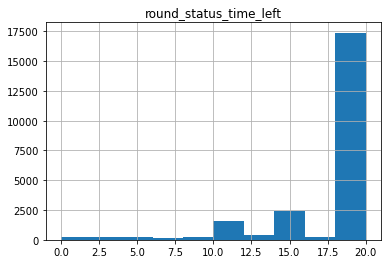

In [41]:
df.hist('round_status_time_left')

In [42]:
dummy_map = pd.get_dummies(df['map'], drop_first = False)
df = pd.concat([df,dummy_map], axis = 1)

In [43]:
df.loc[:, 'ct_score'] = df.current_score.map(lambda x: x[0])
df.loc[:, 't_score'] = df.current_score.map(lambda x: x[1])

df['score_diff'] = df['ct_score'] - df['t_score']

In [44]:
df['new_ct'] = df['money_ct'] + df['total_value_ct']
df['new_t'] = df['money_t'] + df['total_value_t']
df['new_diff'] = df['new_ct'] - df['new_t']

In [45]:
# sns.boxplot(x = 'round_status', y = 'money_diff', data = df)

In [46]:
# sns.boxplot(x = 'round_status', y = 'value_diff', data = df)

In [47]:
# sns.boxplot(x = 'round_status', y = 'health_diff', data = df)

In [48]:
# sns.boxplot(x = 'round_status', y = 'player_diff', data = df)

In [49]:
df = df.drop(['alive_players','map', 'active_smokes', 'active_molotovs', 'previous_kills',
              'round_winner','planted_bomb','inventory_ct','inventory_t','t_items','ct_items', 
              'round_status','current_score','round_status_time_left', 'money_ct','money_t', 
             'total_value_t', 'total_value_ct'], axis = 1 )

In [50]:
df.head()

,target,ct_utility,t_utility,util_diff,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,new_ct,new_t,new_diff
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5000.0,5000.0,0.0
1,1,1,4,-3,0,1,0,0,0,0,0,0,0,0,0,4800.0,4600.0,200.0
4,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,20998.0,11750.0,9248.0
9,0,2,0,2,0,1,0,0,0,0,0,0,2,0,2,27024.0,24450.0,2574.0
15,1,0,1,-1,0,1,0,0,0,0,0,0,2,1,1,10700.0,29331.0,-18631.0


In [51]:
df.describe()

,target,ct_utility,t_utility,util_diff,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,new_ct,new_t,new_diff
count,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000
mean,0.513593,4.049603,3.438625,0.610979,0.001214,0.180983,0.194207,0.151455,0.143130,0.135065,0.101288,0.092659,7.082426,7.182630,-0.100204,28288.341239,27552.504314,735.836925
std,0.499826,5.626369,5.041536,6.148150,0.034823,0.385012,0.395598,0.358499,0.350213,0.341800,0.301716,0.289961,4.675862,4.638725,4.302939,18363.832805,18106.186846,20435.821871
min,0.000000,0.000000,0.000000,-20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,0.000000,0.000000,-71775.000000
25%,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,4.000000,-3.000000,12800.000000,14100.000000,-11834.250000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,7.000000,0.000000,27550.000000,25200.000000,0.000000
75%,1.000000,5.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,11.000000,3.000000,38912.250000,38266.500000,13670.250000
max,1.000000,20.000000,21.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,32.000000,33.000000,14.000000,102974.500000,101300.000000,79424.500000


In [52]:
df.shape

(23063, 18)

In [53]:
display(file = 'csgo_pair.png')

In [54]:
# pair_plot = sns.pairplot(df, hue = 'target')
# pair_plot.savefig('csgo_pair')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7cb097a50>]],
      dtype=object)

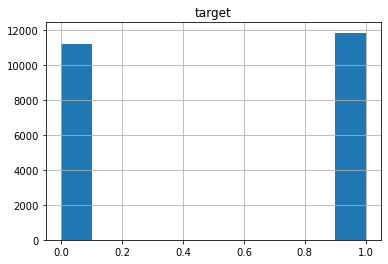

In [55]:
df.hist('target')

In [56]:
df.groupby('target').mean()

,ct_utility,t_utility,util_diff,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,new_ct,new_t,new_diff
target,,,,,,,,,,,,,,,,,
0,3.38563,3.932697,-0.547067,0.000802,0.192102,0.209663,0.145302,0.128454,0.132555,0.093689,0.097433,6.784008,7.203512,-0.419504,25234.090524,29881.019032,-4646.928508
1,4.67843,2.970705,1.707725,0.001604,0.170452,0.179569,0.157282,0.157028,0.137442,0.108485,0.088138,7.365049,7.162854,0.202195,31180.919080,25347.246560,5833.672520


In [89]:
X, y = df.drop(['target','ct_utility','t_utility','util_diff'], axis = 1), df.target


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)


In [92]:
accuracy_score(y_test,np.array([1]*len(X_test)))

0.5234131113423517

In [93]:
X_train.shape

(17297, 14)

In [94]:
X_train.head()

,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,new_ct,new_t,new_diff
60929,0,0,0,0,1,0,0,0,10,10,0,46703.0,16850.0,29853.0
55445,0,0,0,0,0,1,0,0,4,9,-5,32578.5,62200.0,-29621.5
67029,0,0,0,0,0,0,0,1,6,9,-3,5000.0,4600.0,400.0
10554,0,0,0,0,0,0,1,0,15,12,3,83533.0,20550.0,62983.0
6495,0,0,1,0,0,0,0,0,8,7,1,5000.0,5000.0,0.0


In [95]:
y_train.shape

(17297,)

In [96]:
y_train

60929    1
55445    1
67029    0
10554    0
6495     0
        ..
44936    1
81917    0
20343    0
3314     0
59878    1
Name: target, Length: 17297, dtype: int64

In [97]:
# std = StandardScaler()
# std.fit(X_train.values)
# X_tr = std.transform(X_train.values)

In [98]:
    
models = []

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
models.append(knn)

lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
models.append(lr)
    
nb = GaussianNB()
nb.fit(X_train, y_train)
models.append(nb)

# svm = SVC(probability = True)
# svm.fit(X_train, y_train)
# models.append(svm)

rfc = RandomForestClassifier(random_state = 42, oob_score = True)
rfc.fit(X_train, y_train)
models.append(rfc)

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
models.append(gb)

xgboost = xgb.XGBClassifier()
xgboost.fit(X_train, y_train)
models.append(xgboost)

for model in models:
        print (type(model).__name__)
        print ('Accuracy: ', accuracy_score(y_test, model.predict(X_test)))
        print('Precision: ', precision_score(y_test, model.predict(X_test)))
        print('Recall: ', recall_score(y_test, model.predict(X_test)))
        print('F1: ',f1_score(y_test, model.predict(X_test)))
        print('\n')
    
        
        
        
    

    

KNeighborsClassifier
Accuracy:  0.6644120707596254
Precision:  0.6823846412933647
Recall:  0.6713055003313453
F1:  0.6767997327543009


LogisticRegression
Accuracy:  0.6106486298994104
Precision:  0.6081118881118881
Recall:  0.7203445990722332
F1:  0.6594873350523283


GaussianNB
Accuracy:  0.6064862989941033
Precision:  0.6455499417022931
Recall:  0.550364479787939
F1:  0.5941692005008048


RandomForestClassifier
Accuracy:  0.7625737079431149
Precision:  0.7780775716694772
Recall:  0.76441351888668
F1:  0.7711850242353334


GradientBoostingClassifier
Accuracy:  0.6368366285119667
Precision:  0.6355633802816901
Recall:  0.7176938369781312
F1:  0.6741363211951447


XGBClassifier
Accuracy:  0.7032604925424905
Precision:  0.7122442351412797
Recall:  0.7266401590457257
F1:  0.7193701820567492




In [99]:
# for model in models:
#         print (type(model).__name__)
#         print ('Accuracy: ', accuracy_score(y_train, model.predict(X_train)))
#         print('Precision: ', precision_score(y_train, model.predict(X_train)))
#         print('Recall: ', recall_score(y_train, model.predict(X_train)))
#         print('F1: ',f1_score(y_train, model.predict(X_train)))
#         print('\n')

In [100]:
rfc.oob_score_

0.7587442909175002

In [101]:
#RandomForestClassifier no util
# Accuracy:  0.7625737079431149
# Precision:  0.7780775716694772
# Recall:  0.76441351888668
# F1:  0.7711850242353334



# RandomForestClassifier drop first maps 
# Accuracy:  0.7365591397849462
# Precision:  0.7480966567361801
# Recall:  0.7488402915838304
# F1:  0.748468289451896



# with dummied maps

# RandomForestClassifier
# Accuracy:  0.7351716961498439
# Precision:  0.7453109575518263
# Recall:  0.7504970178926441
# F1:  0.7478949975235265




# RandomForestClassifier
# Accuracy:  0.7105445716267776
# Precision:  0.7170904409398133
# Recall:  0.7382372432074221
# F1:  0.7275102040816327






KNeighborsClassifier  AUC =  0.7277568215163169
LogisticRegression  AUC =  0.6427860541747091
GaussianNB  AUC =  0.6350435716607681
RandomForestClassifier  AUC =  0.8565003718590929
GradientBoostingClassifier  AUC =  0.7015725877630866
XGBClassifier  AUC =  0.7737981981955911


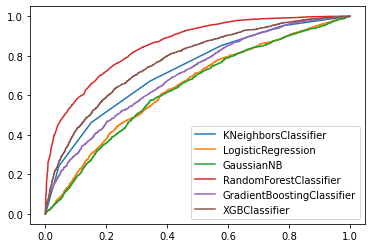

In [102]:
labels = []
for model in models:
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label = model)
    name = type(model).__name__
    print(name, " AUC = ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    labels.append(name)

plt.legend(labels = labels)

In [103]:
pprint.pprint(list(zip(X_train.columns ,rfc.feature_importances_)))

[('de_cache', 0.0006439504597885622),
 ('de_dust2', 0.013902383856492527),
 ('de_inferno', 0.013487121992542707),
 ('de_mirage', 0.014055900425323469),
 ('de_nuke', 0.012422062235534296),
 ('de_overpass', 0.013919375901864848),
 ('de_train', 0.012916401220410531),
 ('de_vertigo', 0.011561152863609515),
 ('ct_score', 0.09355478588554694),
 ('t_score', 0.0944290118652796),
 ('score_diff', 0.09507292393966692),
 ('new_ct', 0.20557676029491856),
 ('new_t', 0.20358162954411585),
 ('new_diff', 0.2148765395149057)]


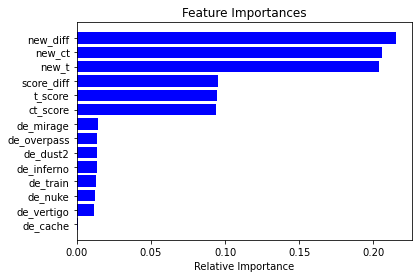

In [104]:
features = X_train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [105]:
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)

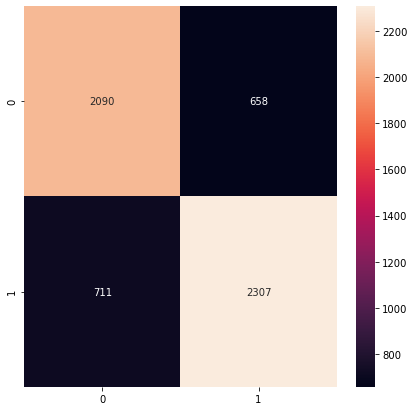

In [106]:
to_plot = confusion_matrix(y_test, pred)
plt.figure(figsize = (7,7))
sns_plot = sns.heatmap(to_plot, annot = True,fmt = 'g')
sns_plot

In [107]:
y_test = np.asarray(y_test)
misclassified = np.where(y_test != pred)

In [108]:
misclass_df =  X_test.iloc[misclassified[0],:]

In [109]:
misclass_df.shape

(1369, 14)

In [110]:
misclass_df.head()

,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,new_ct,new_t,new_diff
973,0,1,0,0,0,0,0,0,13,13,0,19800.0,40654.5,-20854.5
25892,0,0,0,0,0,0,1,0,18,17,1,52598.0,22750.0,29848.0
55364,0,0,0,0,0,1,0,0,1,0,1,20500.0,11750.0,8750.0
50642,0,1,0,0,0,0,0,0,2,4,-2,33350.0,49070.5,-15720.5
52681,0,0,0,0,1,0,0,0,7,8,-1,5000.0,5000.0,0.0


In [111]:
misclass_pred = pd.Series(pred[misclassified[0]])

truth = pd.Series(y_test[misclassified[0]])

In [112]:
misclass_df['truth'] = pred[misclassified[0]]
misclass_df['misclass_pred'] = y_test[misclassified[0]]

/home/ethan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ethan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [113]:
misclass_df.head(20)

,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,new_ct,new_t,new_diff,truth,misclass_pred
973,0,1,0,0,0,0,0,0,13,13,0,19800.0,40654.5,-20854.5,0,1
25892,0,0,0,0,0,0,1,0,18,17,1,52598.0,22750.0,29848.0,1,0
55364,0,0,0,0,0,1,0,0,1,0,1,20500.0,11750.0,8750.0,0,1
50642,0,1,0,0,0,0,0,0,2,4,-2,33350.0,49070.5,-15720.5,0,1
52681,0,0,0,0,1,0,0,0,7,8,-1,5000.0,5000.0,0.0,0,1
30526,0,0,0,1,0,0,0,0,8,3,5,44600.0,34802.5,9797.5,1,0
56669,0,0,0,0,0,1,0,0,2,3,-1,22600.0,46800.0,-24200.0,0,1
55677,0,0,0,0,0,1,0,0,24,25,-1,60600.0,91205.0,-30605.0,1,0
39921,0,1,0,0,0,0,0,0,4,10,-6,16650.0,52842.0,-36192.0,0,1
81651,0,0,0,0,1,0,0,0,11,14,-3,54309.0,28000.0,26309.0,1,0


In [114]:
misclass_df.shape

(1369, 16)

In [115]:
misclass_df.describe()

,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,new_ct,new_t,new_diff,truth,misclass_pred
count,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000
mean,0.003652,0.170928,0.221329,0.155588,0.142440,0.130022,0.092038,0.084003,7.010226,7.224982,-0.214755,29380.077794,29033.889335,346.188459,0.480643,0.519357
std,0.060346,0.376583,0.415294,0.362597,0.349628,0.336450,0.289185,0.277494,4.912529,4.902463,4.142991,18727.832106,18825.600529,18845.719900,0.499808,0.499808
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.000000,4600.000000,4600.000000,-70305.500000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,-3.000000,14200.000000,16300.000000,-10673.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,7.000000,0.000000,28750.000000,26600.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,10.000000,2.000000,39765.500000,40251.500000,10985.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,32.000000,32.000000,13.000000,95750.000000,96633.500000,71276.500000,1.000000,1.000000


In [116]:
df.describe()

,target,ct_utility,t_utility,util_diff,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,ct_score,t_score,score_diff,new_ct,new_t,new_diff
count,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000,23063.000000
mean,0.513593,4.049603,3.438625,0.610979,0.001214,0.180983,0.194207,0.151455,0.143130,0.135065,0.101288,0.092659,7.082426,7.182630,-0.100204,28288.341239,27552.504314,735.836925
std,0.499826,5.626369,5.041536,6.148150,0.034823,0.385012,0.395598,0.358499,0.350213,0.341800,0.301716,0.289961,4.675862,4.638725,4.302939,18363.832805,18106.186846,20435.821871
min,0.000000,0.000000,0.000000,-20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,0.000000,0.000000,-71775.000000
25%,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,4.000000,-3.000000,12800.000000,14100.000000,-11834.250000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,7.000000,0.000000,27550.000000,25200.000000,0.000000
75%,1.000000,5.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,11.000000,3.000000,38912.250000,38266.500000,13670.250000
max,1.000000,20.000000,21.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,32.000000,33.000000,14.000000,102974.500000,101300.000000,79424.500000


In [117]:
# round status time left ->separate?

# questions - interaction terms, difference ok because I am always doing ct - t?

# money X health?

#grid search on xgboost and rfc or all models? 

# remove not important features? if not important or if it improves accuracy
# drop first

# poly transforms?

# nn

# positional 
